In [1]:
pip install Augmentor sklearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Hyperparameters
validation_ratio = 0.05
batch_size = 32
learning_rate = 0.001
epochs = 200
path_to_model ="./checkpoints"

# Augmentation hyperparameters
probability_of_transformation = 0.5

In [3]:
#Load datasets
from keras.datasets import cifar10
import numpy as np

(x_train, digit_y_train), (x_test, digit_y_test) = cifar10.load_data()

Using TensorFlow backend.


In [4]:
#Data conversion, spliting, and scaling
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Scale between 0 and 1
x_train = x_train/255.
x_test = x_test/255.


#Convert labels to one hot encoding
y_train = to_categorical(digit_y_train.flatten(),10)
y_test = to_categorical(digit_y_test.flatten(),10)

# Split data training into sub train and validation
partial_x_train, x_validation, partial_y_train, y_validation = train_test_split(
    x_train, 
    y_train, 
    test_size=validation_ratio, 
    shuffle=True
)

In [5]:
# Data augmentation pipelines
import Augmentor
from keras.preprocessing.image import ImageDataGenerator

def augmentor_keras_prprocessing_adaptor(pipeline=None):
    '''
    An adpator to solves scaling conversion problem between augmentor library and ImageDataGenerator
    '''
    def __internalOperation(image):
        if pipeline is not None:
            image = pipeline.keras_preprocess_func()(image)
            image = list(image.getdata())
            image = np.array(image)
            image = image.reshape(( int(np.sqrt(image.shape[0])),int(np.sqrt(image.shape[0])),image.shape[1]))
            return image.astype(np.float) / 255.
        return image
    return __internalOperation


# Extra pipeline for augmentation provided by augmentor
pipeline = Augmentor.Pipeline()
pipeline.flip_left_right(probability_of_transformation)
    
# Merge pipeline into keras built-in image augmentation
training_data_generator = ImageDataGenerator(featurewise_center= True,
                                             width_shift_range=0.1, 
                                             height_shift_range=0.1, 
                                             preprocessing_function=augmentor_keras_prprocessing_adaptor(pipeline))
validation_data_generator = ImageDataGenerator(featurewise_center= True)
testing_data_generator = ImageDataGenerator(featurewise_center= True)

#Mean normalize all data based on entire training set
training_data_generator.fit(x_train)
validation_data_generator.fit(x_train)
testing_data_generator.fit(x_train)


In [6]:

# #Fully Connected Neural Network
# from tensorflow.keras import models, layers, optimizers, callbacks
# import numpy as np

# fc_model = models.Sequential()
# fc_model.add(layers.InputLayer(input_shape=x_train.shape[1:]))
# fc_model.add(layers.Flatten())

# fc_model.add(layers.Dense(2500, activation="relu"))
# fc_model.add(layers.Dense(2000, activation="relu"))
# fc_model.add(layers.Dense(1500, activation="relu"))
# fc_model.add(layers.Dense(1000, activation="relu"))
# fc_model.add(layers.Dense(500, activation="relu"))

# fc_model.add(layers.Dense(10, activation="softmax"))

# fc_model.compile(
#     optimizer=optimizers.Adam(lr=learning_rate),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# print(fc_model.summary())

# fc_model.fit_generator(
#     training_data_generator.flow(partial_x_train,partial_y_train,batch_size),
#     validation_data = validation_data_generator.flow(x_validation,y_validation,batch_size),
#     steps_per_epoch = np.ceil(len(partial_x_train)/batch_size),
#     validation_steps = np.ceil(len(x_validation)/batch_size),
#     initial_epoch = 0,
#     epochs=100
# )86

# result = fc_model.evaluate_generator(
#     generator = testing_data_generator.flow(x_test,y_test,batch_size),
#     steps = np.ceil(len(x_test)/batch_size)
# )
# print("Testing loss = ", result[0])
# print("Testing accuracy = ", result[1])

In [7]:
from keras import callbacks
import numpy as np
import os
import pathlib

#Helper functions
def get_learning_rate (epoch, lr):
    '''
    Hardset learning rate to be use with learningRateScheduler
    '''
    lr = learning_rate
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

class ParameterLogger(callbacks.Callback):
    def __init__(self, epochs_file_path, period):
      self.epochs_file_path = epochs_file_path
      self.period = period
      self.counter = 0 

    def on_epoch_end(self, epoch, logs=None):
        self.counter = self.counter + 1
        if( self.counter == self.period):
          self.counter=0
          with open(self.epochs_file_path, 'w') as f:
            k = epoch+1
            f.write(str(k))

In [8]:
from keras import models, layers, optimizers
import numpy as np
import os
import pathlib

#Build new networks or load existiing one

def build_resnet(filepath):
    '''
    Load existing resnet or create a new one
    '''
    #Create folders for storing weights
    pathlib.Path(os.path.dirname(filepath)).mkdir(parents=True, exist_ok=True)

    #Attempt to load weights checkpoint if it existed
    models_file_path = filepath+".h5"
    epochs_file_path = filepath+".txt"

    model = Resnet()
    epochs = 0

    if(os.path.exists(models_file_path)):
        print('Checkpoint detected.')
        try:
            model.load_weights(models_file_path)
            with open(epochs_file_path, 'r') as f:
              epochs = int(f.read())

            print("Load weights from disks")
        except Exception as e:
            print("Fail to load weights due to wrong models architecture ")

    return model, epochs


def ResnetLayers(previous_layers, filters=128, kernel_size=(3,3), padding='same', strides=1 , activation='relu'):
    '''
    Resnet block v2 pre activation
    '''
    #First Conv2D layer
    main_path = layers.BatchNormalization()(previous_layers)
    main_path = layers.Activation(activation)(main_path)
    main_path = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding = padding, strides = strides, kernel_initializer='he_normal')(main_path)
      
    #Second Conv2D layer
    main_path = layers.BatchNormalization()(main_path)  
    main_path = layers.Activation(activation)(main_path)
    main_path = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding = padding, kernel_initializer='he_normal')(main_path)
    
    #Check if inputs have the right shape to perform addition
    if main_path.shape[1:] == previous_layers.shape[1:]:
        shortcut_path = previous_layers
    else:
        shortcut_path = layers.Conv2D(filters=filters, kernel_size=(1,1), padding = padding, strides = strides, activation= activation, kernel_initializer='he_normal')(previous_layers)

    #Complete the second Conv2D layer
    main_path = layers.Add()([main_path, shortcut_path])
    return main_path


def Resnet():
    inputs = layers.Input(shape= x_train.shape[1:])

    #First layers
    outputs = layers.Conv2D(filters=16, kernel_size=(3,3), padding = 'same', strides = 1, kernel_initializer='he_normal')(inputs)
    outputs = layers.BatchNormalization()(outputs)
    outputs = layers.Activation('relu')(outputs)

    #Stacks 1
    outputs = ResnetLayers(outputs,  filters=16, kernel_size=(3,3), padding='same', strides=1 , activation='relu')
    outputs = ResnetLayers(outputs,  filters=16, kernel_size=(3,3), padding='same', strides=1 , activation='relu')
    outputs = ResnetLayers(outputs,  filters=16, kernel_size=(3,3), padding='same', strides=1 , activation='relu')

    #Stacks 2
    outputs = ResnetLayers(outputs,  filters=32, kernel_size=(3,3), padding='same', strides=2 , activation='relu')
    outputs = ResnetLayers(outputs,  filters=32, kernel_size=(3,3), padding='same', strides=1 , activation='relu')
    outputs = ResnetLayers(outputs,  filters=32, kernel_size=(3,3), padding='same', strides=1 , activation='relu')

    #Stacks 3
    outputs = ResnetLayers(outputs,  filters=64, kernel_size=(3,3), padding='same', strides=2 , activation='relu')
    outputs = ResnetLayers(outputs,  filters=64, kernel_size=(3,3), padding='same', strides=1 , activation='relu')
    outputs = ResnetLayers(outputs,  filters=64, kernel_size=(3,3), padding='same', strides=1 , activation='relu')


    outputs = layers.AveragePooling2D(pool_size=8)(outputs)
    outputs = layers.Flatten()(outputs)
    outputs = layers.Dense(10, activation="softmax", kernel_initializer='he_normal')(outputs)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=optimizers.Adam(lr=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [9]:
#Convolutional Neural Network
from keras import models, layers, optimizers, callbacks
import numpy as np
import os
import pathlib

#Form  model path 
filespath = os.path.join(path_to_model+"/cnn_model")
        
#Some callbacks
modelCheckpoint = callbacks.ModelCheckpoint(filespath +".h5",save_best_only=True,save_weights_only=True, period=10)
parameterLogger = ParameterLogger(filespath +".txt",  period=10)
learningRateScheduler = callbacks.LearningRateScheduler(get_learning_rate, verbose = 1)
learningReducer = callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=10, min_lr=5e-7, verbose=1)

#Load saved weights
cnn_model, initial_epoch = build_resnet(filespath)

#Print model
print(cnn_model.summary())

#Start training
cnn_model.fit_generator(
    training_data_generator.flow(partial_x_train,partial_y_train,batch_size),
    validation_data = validation_data_generator.flow(x_validation,y_validation,batch_size),
    steps_per_epoch = np.ceil(len(partial_x_train)/batch_size),
    validation_steps = np.ceil(len(x_validation)/batch_size),
    initial_epoch = initial_epoch,
    epochs=epochs,
    callbacks=[learningRateScheduler, modelCheckpoint, parameterLogger]
)

#Evaluate test set
result = cnn_model.evaluate_generator(
    generator = testing_data_generator.flow(x_test,y_test,batch_size),
    steps = np.ceil(len(x_test)/batch_size)
)

#Print results
print("Testing loss = ", result[0])
print("Testing accuracy = ", result[1])

Checkpoint detected.
Load weights from disks
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________

Epoch 71/200

Epoch 00071: LearningRateScheduler setting learning rate to 0.001.
1485/1485 [==============================] - 70s 47ms/step - loss: 0.2564 - accuracy: 0.9101 - val_loss: 0.1165 - val_accuracy: 0.8916
Epoch 72/200

Epoch 00072: LearningRateScheduler setting learning rate to 0.001.
1485/1485 [==============================] - 65s 44ms/step - loss: 0.2529 - accuracy: 0.9121 - val_loss: 0.8015 - val_accuracy: 0.9064
Epoch 73/200

Epoch 00073: LearningRateScheduler setting learning rate to 0.001.
1485/1485 [==============================] - 65s 44ms/step - loss: 0.2509 - accuracy: 0.9121 - val_loss: 0.0601 - val_accuracy: 0.8952
Epoch 74/200

Epoch 00074: LearningRateScheduler setting learning rate to 0.001.
1485/1485 [==============================] - 66s 44ms/step - loss: 0.2406 - accuracy: 0.9160 - val_loss: 0.0224 - val_accuracy: 0.9132
Epoch 75/200

Epoch 00075: LearningRateScheduler setting learning rate to 0.001.
1485/1485 [==============================] - 67s 45ms/s

1485/1485 [==============================] - 63s 43ms/step - loss: 0.1043 - accuracy: 0.9632 - val_loss: 0.0101 - val_accuracy: 0.9324
Epoch 109/200

Epoch 00109: LearningRateScheduler setting learning rate to 0.0001.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.1009 - accuracy: 0.9636 - val_loss: 0.0842 - val_accuracy: 0.9320
Epoch 110/200

Epoch 00110: LearningRateScheduler setting learning rate to 0.0001.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.1028 - accuracy: 0.9637 - val_loss: 0.0043 - val_accuracy: 0.9360
Epoch 111/200

Epoch 00111: LearningRateScheduler setting learning rate to 0.0001.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.1022 - accuracy: 0.9636 - val_loss: 0.0518 - val_accuracy: 0.9328
Epoch 112/200

Epoch 00112: LearningRateScheduler setting learning rate to 0.0001.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0978 - accuracy: 0.9650 - val_loss: 0.0084 - val_accuracy: 

Epoch 146/200

Epoch 00146: LearningRateScheduler setting learning rate to 1e-05.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0830 - accuracy: 0.9708 - val_loss: 1.9164 - val_accuracy: 0.9344
Epoch 147/200

Epoch 00147: LearningRateScheduler setting learning rate to 1e-05.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0825 - accuracy: 0.9693 - val_loss: 2.6195e-05 - val_accuracy: 0.9336
Epoch 148/200

Epoch 00148: LearningRateScheduler setting learning rate to 1e-05.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0831 - accuracy: 0.9698 - val_loss: 0.0013 - val_accuracy: 0.9364
Epoch 149/200

Epoch 00149: LearningRateScheduler setting learning rate to 1e-05.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0827 - accuracy: 0.9704 - val_loss: 2.5182e-05 - val_accuracy: 0.9364
Epoch 150/200

Epoch 00150: LearningRateScheduler setting learning rate to 1e-05.
1485/1485 [==============================]

1485/1485 [==============================] - 63s 43ms/step - loss: 0.0822 - accuracy: 0.9703 - val_loss: 0.3479 - val_accuracy: 0.9344
Epoch 184/200

Epoch 00184: LearningRateScheduler setting learning rate to 5e-07.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0808 - accuracy: 0.9709 - val_loss: 1.3113e-05 - val_accuracy: 0.9340
Epoch 185/200

Epoch 00185: LearningRateScheduler setting learning rate to 5e-07.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0828 - accuracy: 0.9696 - val_loss: 0.0085 - val_accuracy: 0.9360
Epoch 186/200

Epoch 00186: LearningRateScheduler setting learning rate to 5e-07.
1485/1485 [==============================] - 64s 43ms/step - loss: 0.0795 - accuracy: 0.9723 - val_loss: 0.0528 - val_accuracy: 0.9340
Epoch 187/200

Epoch 00187: LearningRateScheduler setting learning rate to 5e-07.
1485/1485 [==============================] - 63s 43ms/step - loss: 0.0794 - accuracy: 0.9717 - val_loss: 2.6553e-05 - val_accura

In [10]:
#Visualization Hyperparameters

#Color options
colors= ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

#Image to apply features map onto
img = x_train[0]

#Maximum numbers of images per layers for each visualization
image_cap = 14

D:\Anaconda3\envs\551\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


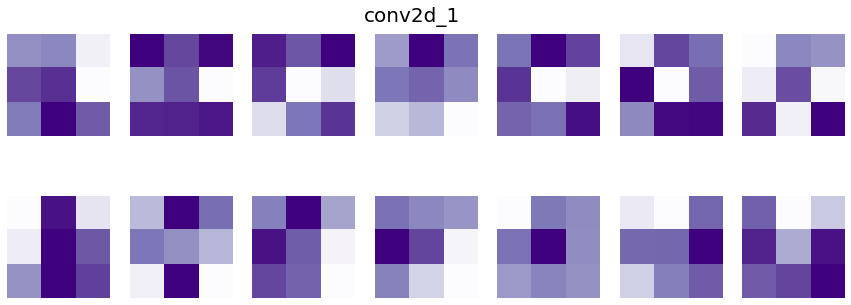

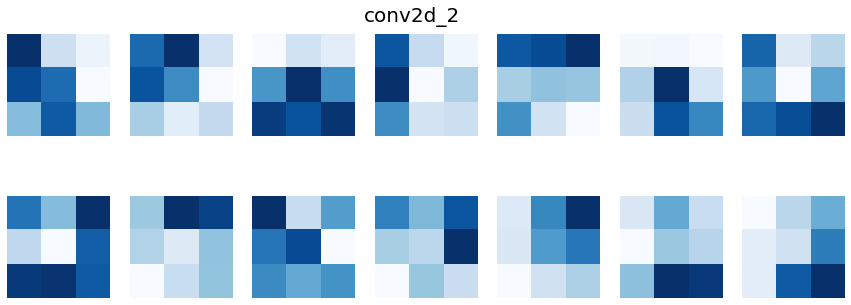

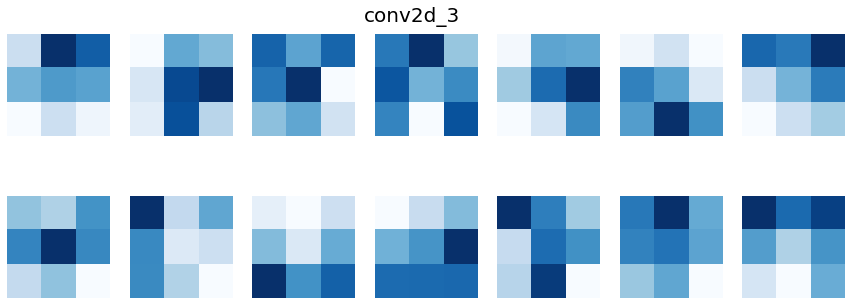

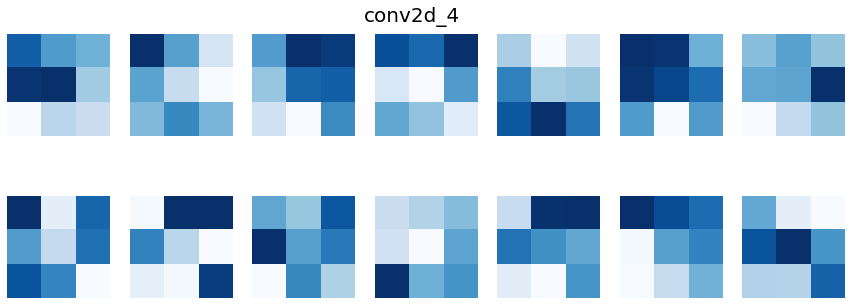

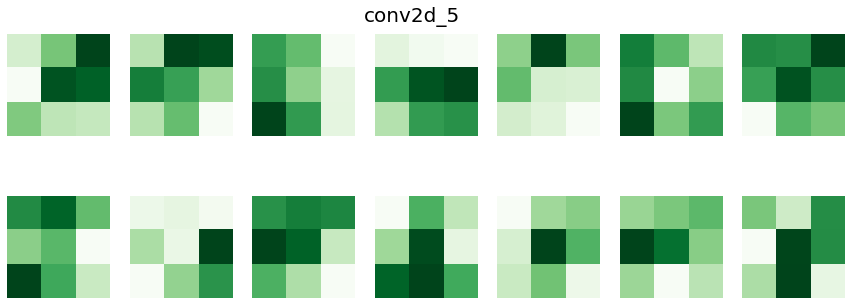

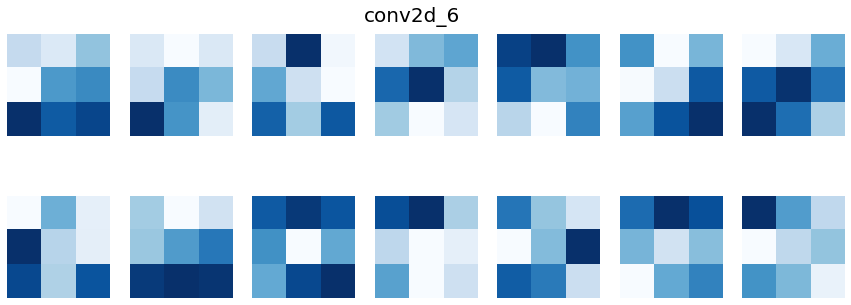

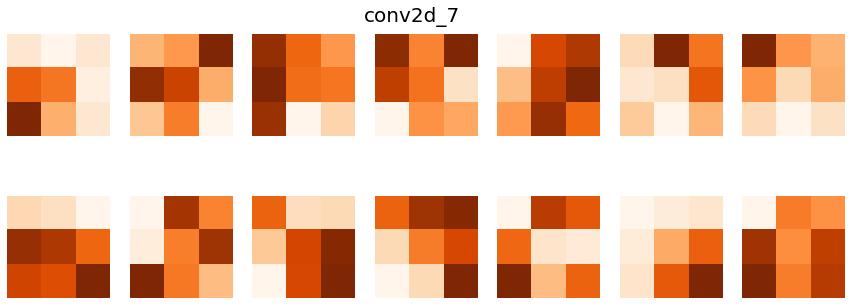

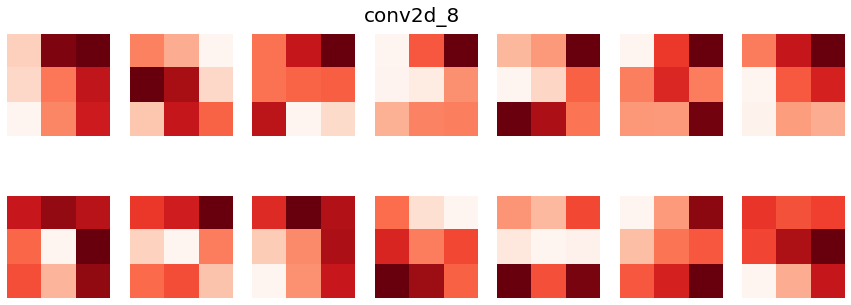

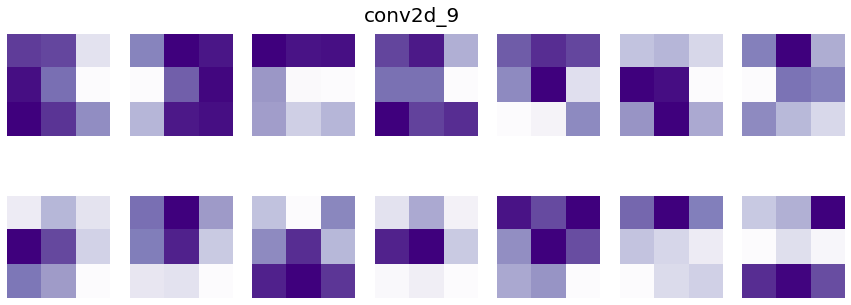

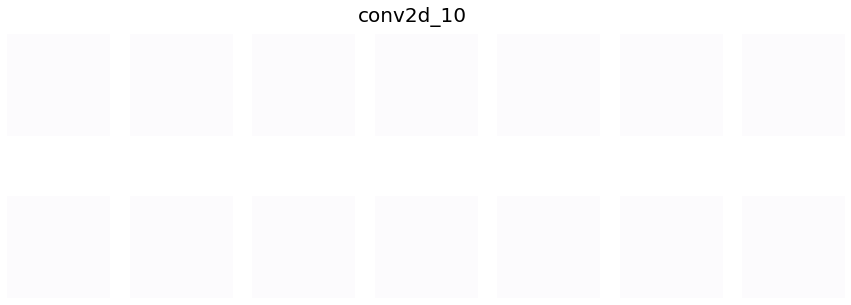

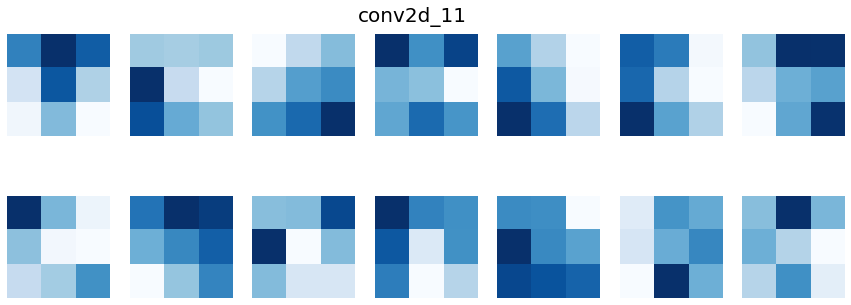

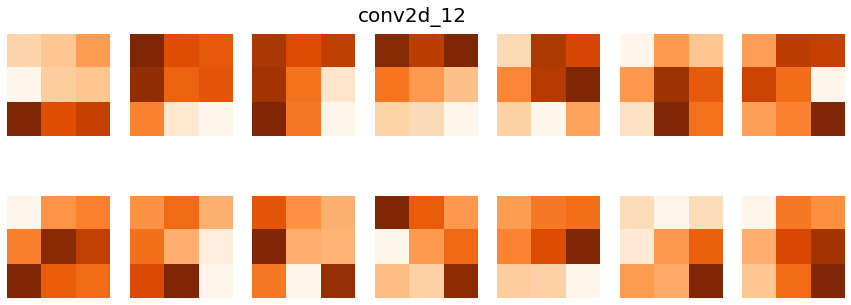

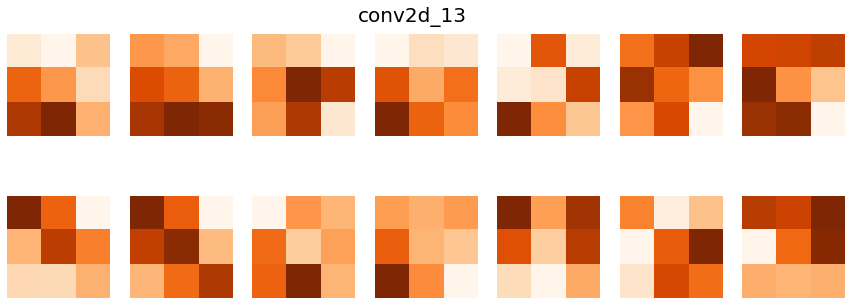

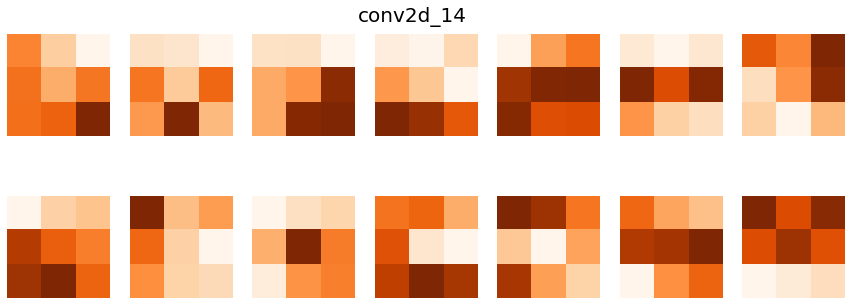

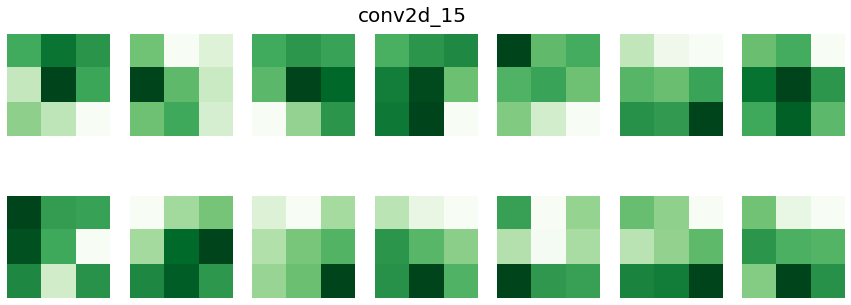

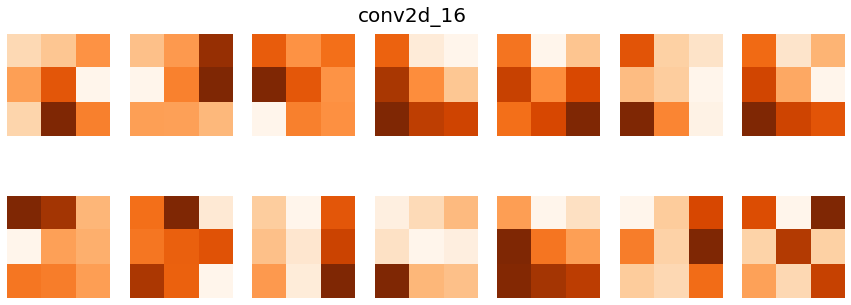

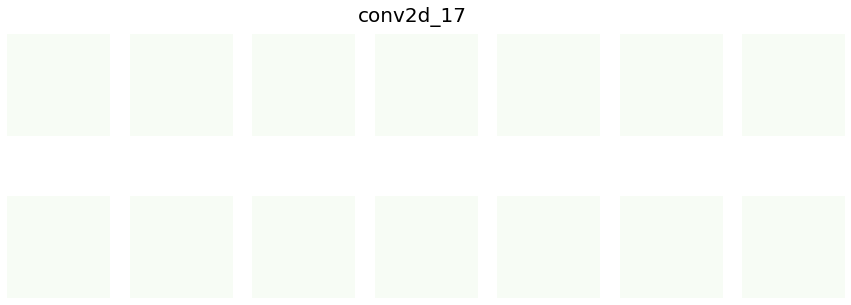

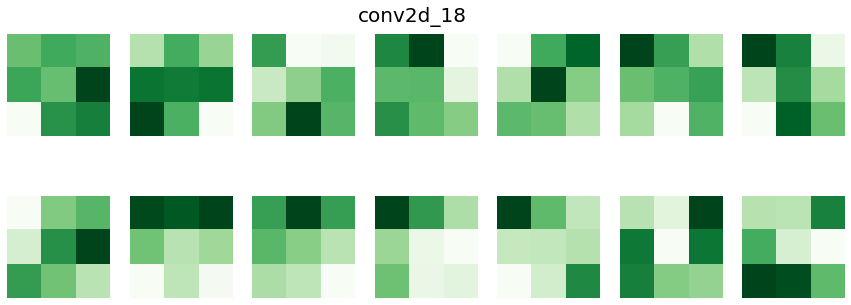

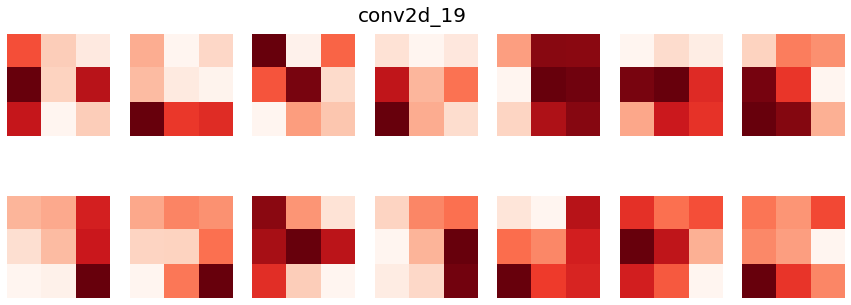

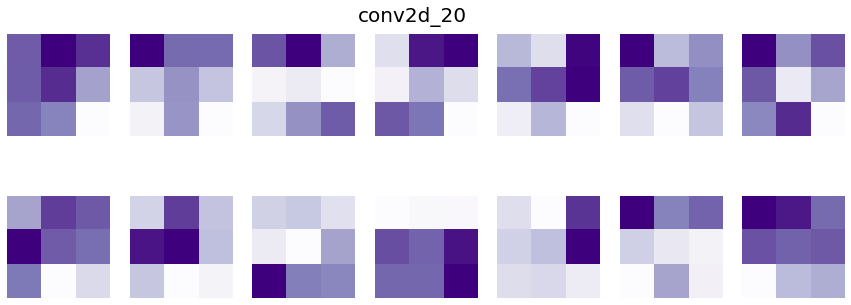

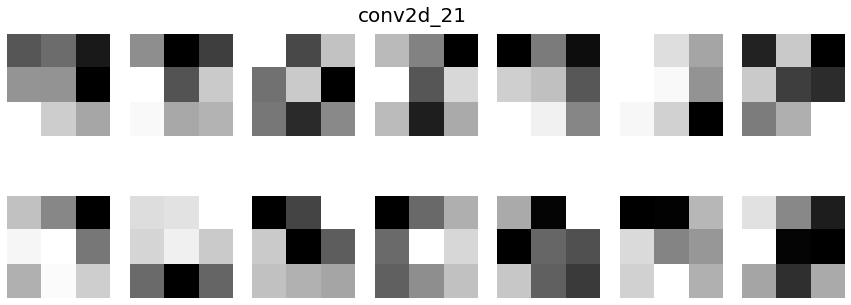

In [11]:
#Visualize Filters

#Imports
import matplotlib.pyplot as plt
import numpy as np

#Helper functions to convert between 1d coordinate and 2d coordinate
def index_to_2d_index (v, width):
    column = v % width
    row = v / width 
    return int(row), int(column)

def two_d_index_to_index(row, column, width):
    return column + (row * width)


#Loop throughts all layers and identify conv2d layers
for layer in cnn_model.layers:
    if 'conv' in layer.name:
        
        #Set internal counter for maximum images per layers
        cap_per_layers = image_cap
        
        #Extract weights and bias
        weights, bias = layer.get_weights()
        kernel_height, kernel_width, num_channels, num_kernels = weights.shape
        
        #Determine a minimum numbers of images slots requires per layers
        width = 7
        height = min(int(np.ceil(num_channels*num_kernels/width)),int(np.ceil(cap_per_layers/width)))
        
        #Set image settings
        fig, axs = plt.subplots(height, width, figsize=(15,2.5*height), squeeze = False)
        fig.suptitle(layer.name, fontsize=20)
        fig.subplots_adjust(top=(height/80)*0.03+0.95)
        
        color_index = np.random.randint(len(colors))
        
        #Start drawing
        for j in range(num_kernels):
            for i in range(num_channels):
                
                #Determines which index to draw at
                index = i + j * num_channels
                
                #Convert to images slots 2d coordinate
                row,column = index_to_2d_index(index,width)
                
                #Draw images
                axs[row,column].imshow(weights[:,:,i,j], cmap=colors[color_index])
                axs[row,column].set_axis_off()
                
                #Update internal image counter
                cap_per_layers = cap_per_layers -1 
                if cap_per_layers<=0:
                    break
            if cap_per_layers<=0:
                    break
        
        #Remove extra image slots that weren't use
        for k in range(1+i + j * num_channels, width*height):
            row,column = index_to_2d_index(k,width)
            fig.delaxes(axs[row][column])
plt.show()


         

D:\Anaconda3\envs\551\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


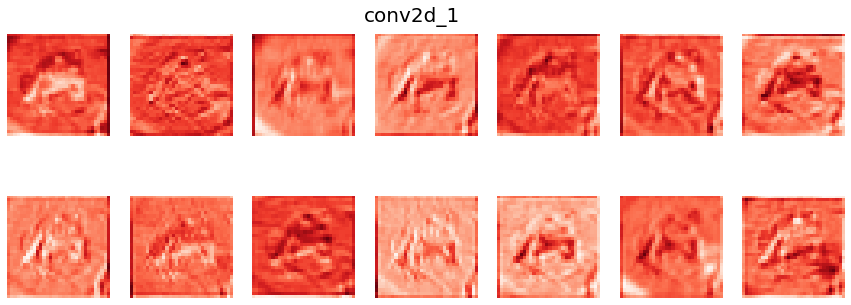

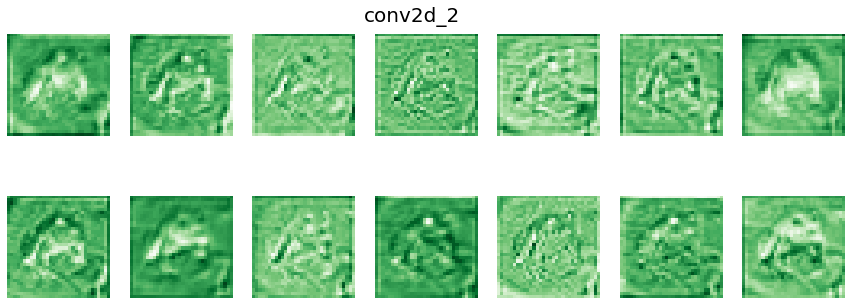

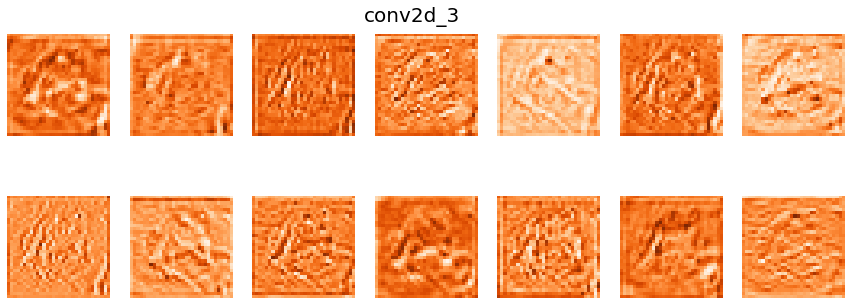

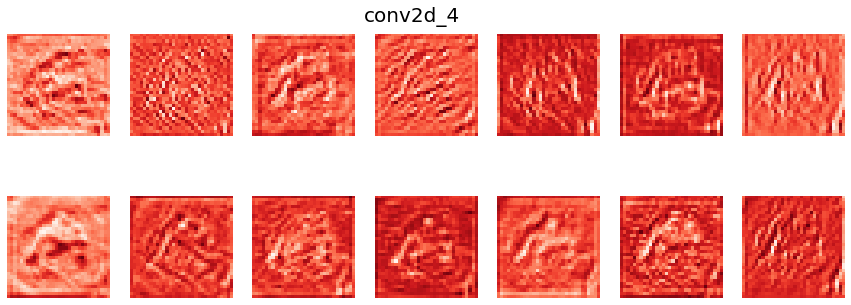

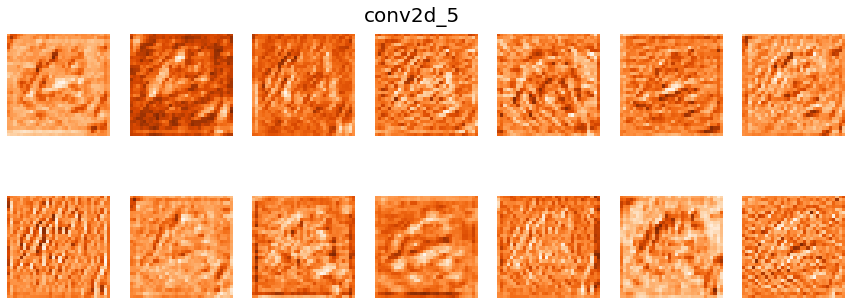

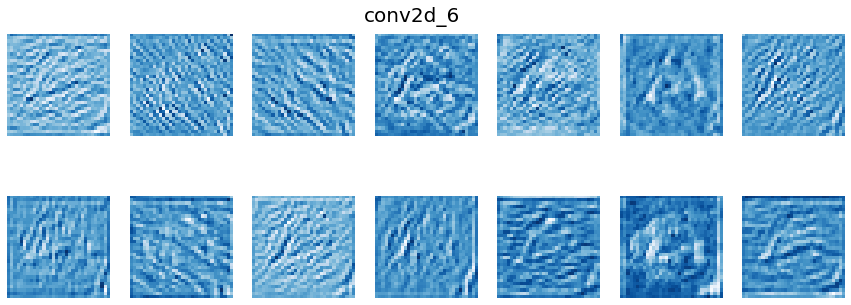

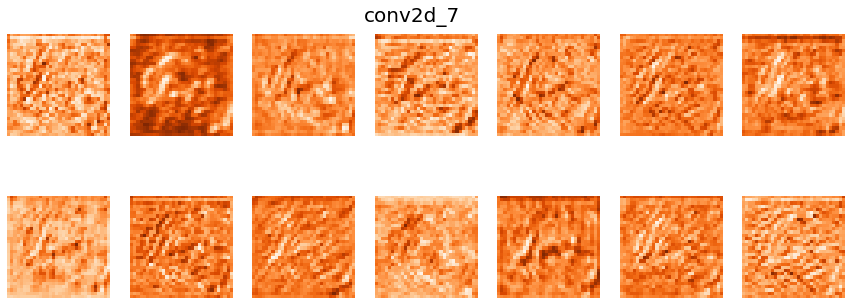

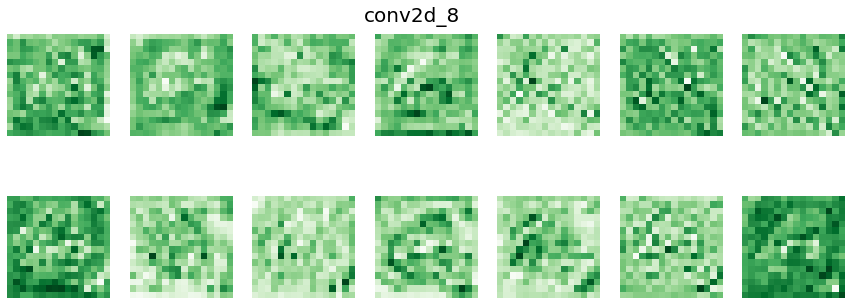

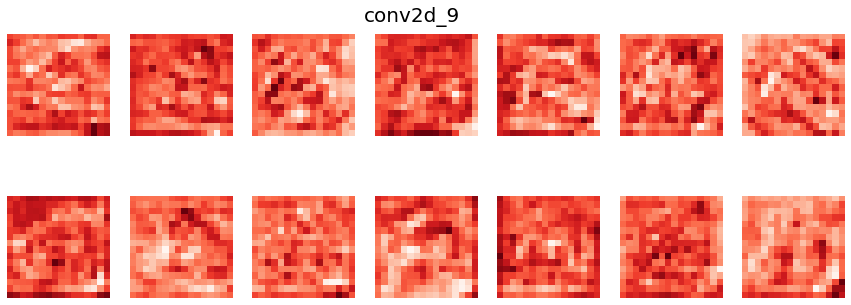

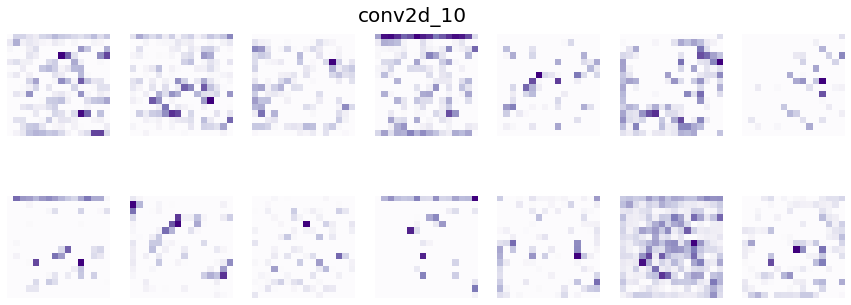

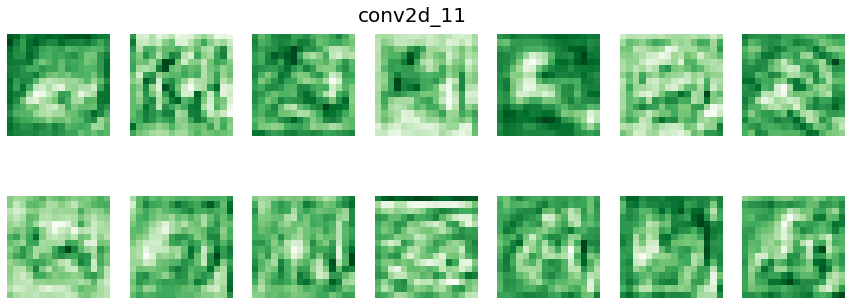

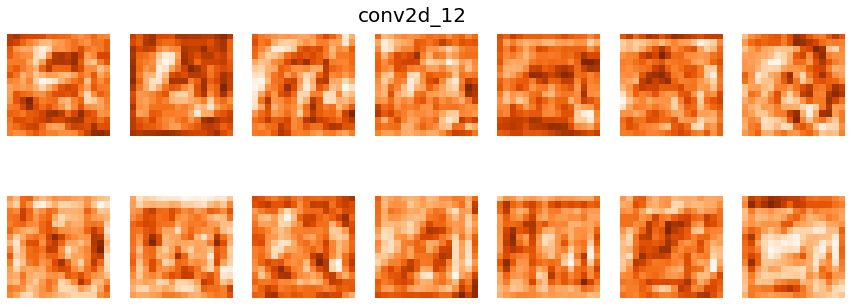

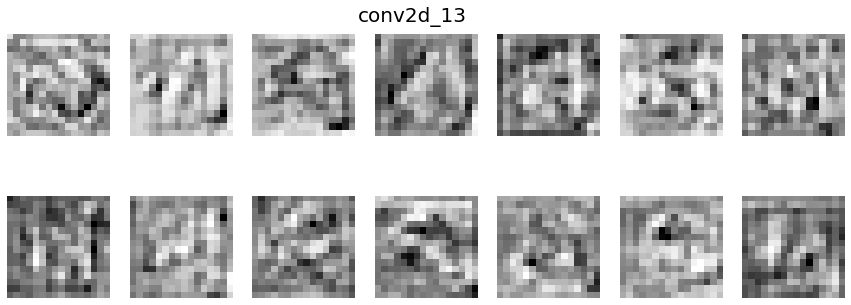

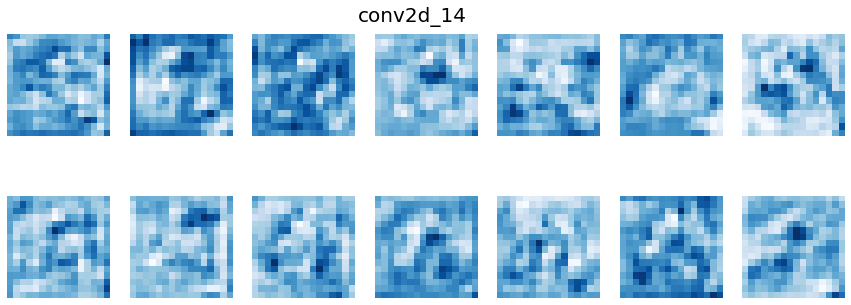

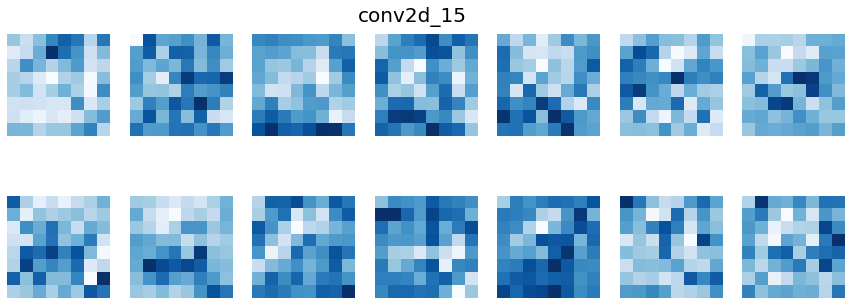

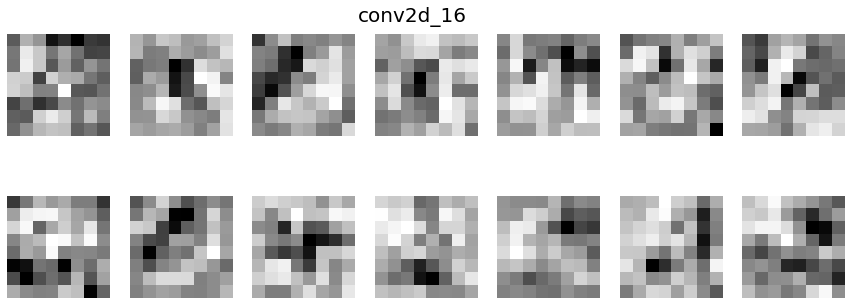

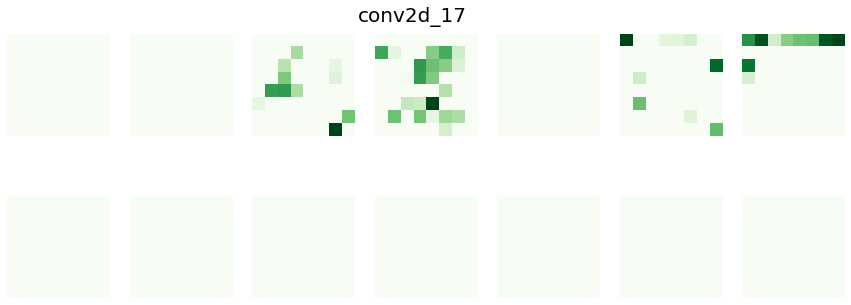

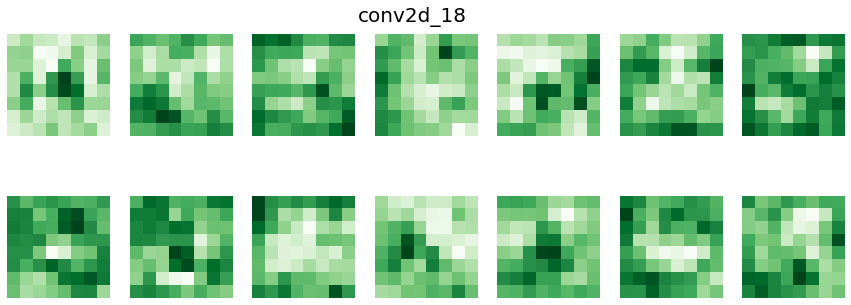

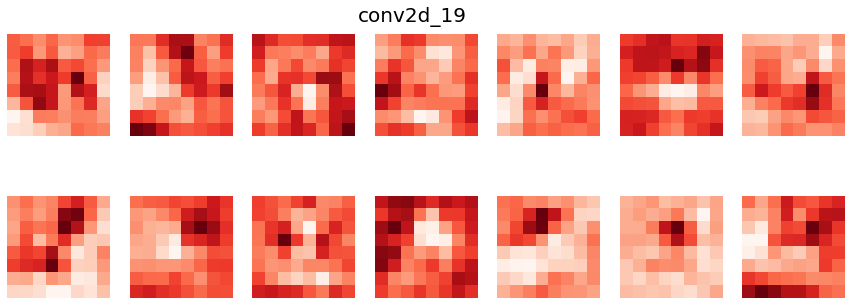

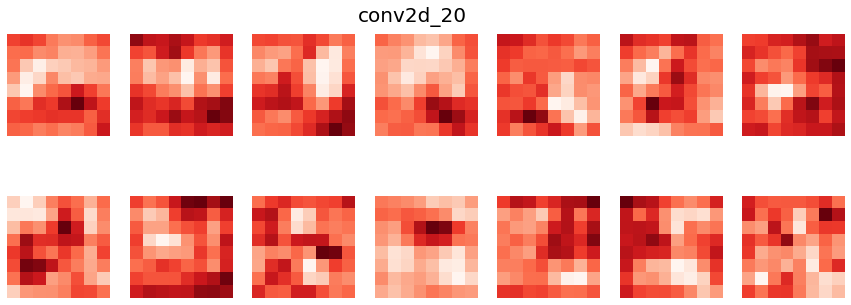

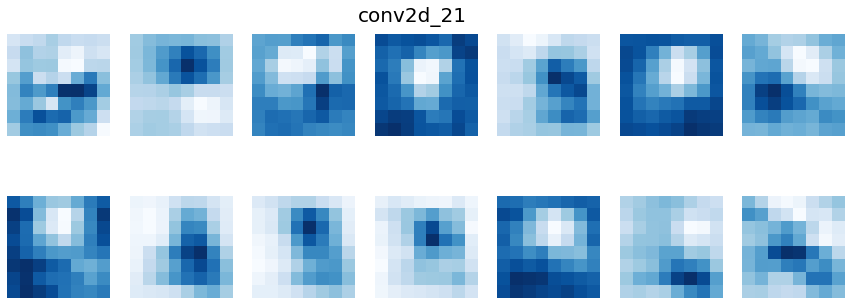

In [12]:
#Visualize Features

#Imports
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model

#Helper functions to convert between 1d coordinate and 2d coordinate
def index_to_2d_index (v, width):
    column = v % width
    row = v / width 
    return int(row), int(column)

def two_d_index_to_index(row, column, width):
    return column + (row * width)

#Extract information from orignal models
names=[]
outputs = []
for layer in cnn_model.layers:
    if  'conv' in layer.name:
        names.append(layer.name)
        outputs.append(layer.output)

#Create new model with multiple outputs        
feature_maps_model = Model(inputs = cnn_model.inputs, outputs = outputs) 

#Use new model to predict an images
result = feature_maps_model.predict(np.array([img]))

if len(outputs) ==1:
    result = [result]

#Loop through output from each convolution layer
for index in range(len(outputs)):
    
    #Set internal counter for maximum images per layers
    cap_per_layers = image_cap
    
    #Reshaping output and extract information
    result[index] = np.squeeze(result[index],axis = 0)

    output_width, output_height, num_kernels = result[index].shape
    
    #Determine a minimum numbers of images slots requires per layers
    width = 7
    height = min(int(np.ceil(num_kernels/width)),int(np.ceil(cap_per_layers/width)))
    
    #Set image settings
    fig, axs = plt.subplots(height, width, figsize=(15,2.5*height), squeeze = False)
    fig.suptitle(names[index], fontsize=20)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=(height/80)*0.03+0.95, wspace=None, hspace=None)
    
    color_index = np.random.randint(len(colors))
    
    #Start drawing
    for i in range(num_kernels):
        
        #Convert to images slots 2d coordinate
        row,column = index_to_2d_index(i,width) 
        
        #Draw images
        axs[row,column].imshow(result[index][:,:,i], cmap=colors[color_index])
        axs[row,column].set_axis_off()
        
        #Update counter
        cap_per_layers = cap_per_layers - 1
        if cap_per_layers<=0:
            break
    #Remove extra image slots that weren't use
    for k in range(i+1, width*height):
        row,column = index_to_2d_index(k,width)
        fig.delaxes(axs[row][column])

plt.show()